In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Paths
real_image_dir = "data/training/images"
real_mask_dir = "data/training/groundtruth"
gen_image_dir = "data/training/images_generated"
gen_mask_dir = "data/training/groundtruth_generated"
deepglobe_image_dir = "data/DeepGlobe_images"
deepglobe_mask_dir = "data/DeepGlobe_groundtruth"


In [ ]:
real_images = sorted(os.listdir(real_image_dir))
real_masks = sorted(os.listdir(real_mask_dir))
gen_images = sorted(os.listdir(gen_image_dir))
gen_masks = sorted(os.listdir(gen_mask_dir))
deepglobe_images = sorted(os.listdir(deepglobe_image_dir))
deepglobe_masks = sorted(os.listdir(deepglobe_mask_dir))

print(f"📦 Real images: {len(real_images)}")
assert len(real_images) == len(real_masks), "Mismatch between real images and masks"
print(f"🧪 Generated images: {len(gen_images)}")
assert len(gen_images) == len(gen_masks), "Mismatch between generated images and masks"
print(f"🌍 DeepGlobe images: {len(deepglobe_images)}")
assert len(deepglobe_images) == len(deepglobe_masks), "Mismatch between DeepGlobe images and masks"

📦 Real images: 100
🟩 Real masks: 100
🧪 Generated images: 1003
🧪 Generated masks: 1003
🌍 DeepGlobe images: 6226
🌍 DeepGlobe masks: 6226


In [11]:
def get_image_info(path):
    img = Image.open(path)
    return img.size, img.mode, np.array(img).dtype

# Sample checks
print("Real image example:", get_image_info(os.path.join(real_image_dir, real_images[0])))
print("Real mask example:", get_image_info(os.path.join(real_mask_dir, real_masks[0])))
print("Generated image example:", get_image_info(os.path.join(gen_image_dir, gen_images[0])))
print("Generated mask example:", get_image_info(os.path.join(gen_mask_dir, gen_masks[0])))
print("DeepGlobe image example:", get_image_info(os.path.join(deepglobe_image_dir, deepglobe_images[0])))
print("DeepGlobe mask example:", get_image_info(os.path.join(deepglobe_mask_dir, deepglobe_masks[0])))

Real image example: ((400, 400), 'RGB', dtype('uint8'))
Real mask example: ((400, 400), 'L', dtype('uint8'))
Generated image example: ((416, 416), 'RGB', dtype('uint8'))
Generated mask example: ((416, 416), 'L', dtype('uint8'))
DeepGlobe image example: ((1024, 1024), 'RGB', dtype('uint8'))
DeepGlobe mask example: ((1024, 1024), 'L', dtype('uint8'))


Calculating coverage: 100%|██████████| 6226/6226 [00:22<00:00, 279.97it/s]


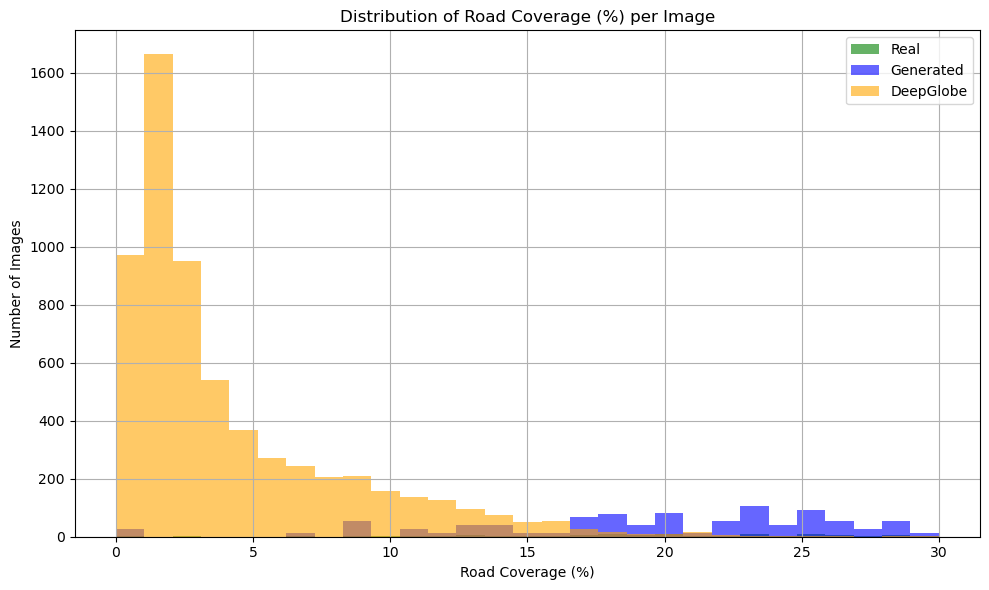

In [13]:
def calculate_coverage(path_list, base_path):
    ratios = []
    for fname in tqdm(path_list, desc="Calculating coverage"):
        mask = np.array(Image.open(os.path.join(base_path, fname)))
        mask_bin = (mask > 128).astype(np.uint8)  # thresholding for binarization
        ratio = np.sum(mask_bin) / mask_bin.size
        ratios.append(ratio)
    return ratios

real_coverage = calculate_coverage(real_masks, real_mask_dir)
gen_coverage = calculate_coverage(gen_masks, gen_mask_dir)
deepglobe_coverage = calculate_coverage(deepglobe_masks, deepglobe_mask_dir)

# Convert coverage ratios to percentages
real_coverage_pct = np.array(real_coverage) * 100
gen_coverage_pct = np.array(gen_coverage) * 100
deepglobe_coverage_pct = np.array(deepglobe_coverage) * 100

# Plot histogram
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 30, 30)  # You can adjust the upper limit (e.g., 50) if needed

plt.hist(real_coverage_pct, bins=bins, alpha=0.6, label="Real", color='green')
plt.hist(gen_coverage_pct, bins=bins, alpha=0.6, label="Generated", color='blue')
plt.hist(deepglobe_coverage_pct, bins=bins, alpha=0.6, label="DeepGlobe", color='orange')

plt.title("Distribution of Road Coverage (%) per Image")
plt.xlabel("Road Coverage (%)")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


RGB Histogram (data/training/images_generated): 100%|██████████| 1003/1003 [00:07<00:00, 131.72it/s]


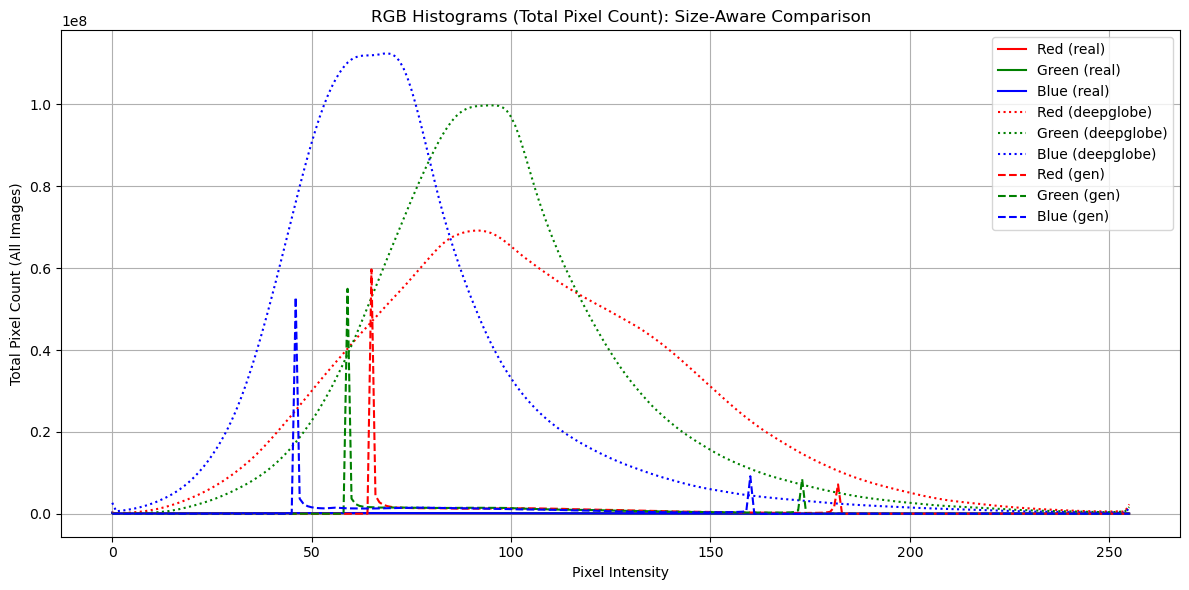

In [18]:
def compute_rgb_histograms_weighted(image_dir, image_list, sample_size=None):
    r_total = np.zeros(256)
    g_total = np.zeros(256)
    b_total = np.zeros(256)
    
    if sample_size:
        image_list = image_list[:sample_size]

    for fname in tqdm(image_list, desc=f"RGB Histogram ({image_dir})"):
        img = np.array(Image.open(os.path.join(image_dir, fname)))

        if img.ndim == 3 and img.shape[2] == 3:
            r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
            r_total += np.histogram(r.flatten(), bins=256, range=(0, 255))[0]
            g_total += np.histogram(g.flatten(), bins=256, range=(0, 255))[0]
            b_total += np.histogram(b.flatten(), bins=256, range=(0, 255))[0]

    return r_total, g_total, b_total

# Compute size-aware histograms
real_r, real_g, real_b = compute_rgb_histograms_weighted(real_image_dir, real_images)
deepglobe_r, deepglobe_g, deepglobe_b = compute_rgb_histograms_weighted(deepglobe_image_dir, deepglobe_images)
gen_r, gen_g, gen_b = compute_rgb_histograms_weighted(gen_image_dir, gen_images)

# Plot
plt.figure(figsize=(12, 6))
x = np.arange(256)

# Real images (solid)
plt.plot(x, real_r, label='Red (real)', color='red', linestyle='-')
plt.plot(x, real_g, label='Green (real)', color='green', linestyle='-')
plt.plot(x, real_b, label='Blue (real)', color='blue', linestyle='-')

# DeepGlobe images (dashed)
plt.plot(x, deepglobe_r, label='Red (deepglobe)', color='red', linestyle=':')
plt.plot(x, deepglobe_g, label='Green (deepglobe)', color='green', linestyle=':')
plt.plot(x, deepglobe_b, label='Blue (deepglobe)', color='blue', linestyle=':')

# Optional: Generated (dotted)
plt.plot(x, gen_r, label='Red (gen)', color='red', linestyle='--')
plt.plot(x, gen_g, label='Green (gen)', color='green', linestyle='--')
plt.plot(x, gen_b, label='Blue (gen)', color='blue', linestyle='--')

plt.title("RGB Histograms (Total Pixel Count): Size-Aware Comparison")
plt.xlabel("Pixel Intensity")
plt.ylabel("Total Pixel Count (All Images)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--> Data normalisation in dataloader 
import albumentations as A

transform = A.Compose([
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.9),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(),
])


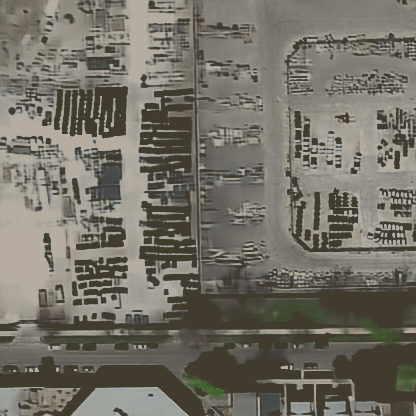

In [7]:
from IPython.display import display
display(Image.open(os.path.join(gen_image_dir, gen_images[0])))


# Not high quality generated data. Had to find another data source. Very rural areas, might be challenging & not allign with the concept

In [8]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Relative paths from project root
input_dir = "data/train"
output_image_dir = "data/DeepGlobe_images"
output_mask_dir = "data/DeepGlobe_groundtruth"

# Make sure output folders exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# List satellite image files
all_files = os.listdir(input_dir)
sat_files = [f for f in all_files if f.endswith('_sat.jpg')]

for sat_file in tqdm(sat_files, desc="Processing DeepGlobe dataset"):
    base_id = sat_file.replace('_sat.jpg', '')
    mask_file = f"{base_id}_mask.png"

    sat_path = os.path.join(input_dir, sat_file)
    mask_path = os.path.join(input_dir, mask_file)

    if not os.path.exists(mask_path):
        print(f"❗️ Skipping {base_id} — Mask not found.")
        continue

    # Output filenames
    new_filename = f"DeepGlobe_{base_id}.png"
    out_image_path = os.path.join(output_image_dir, new_filename)
    out_mask_path = os.path.join(output_mask_dir, new_filename)

    # Convert satellite .jpg → .png
    sat_img = Image.open(sat_path).convert("RGB")
    sat_img.save(out_image_path)

    # Convert mask to binary + save as .png
    mask_img = Image.open(mask_path).convert("L")
    mask_array = np.array(mask_img)
    binary_mask = (mask_array > 128).astype(np.uint8) * 255
    Image.fromarray(binary_mask).save(out_mask_path)

print("✅ All DeepGlobe files processed and saved.")


Processing DeepGlobe dataset: 100%|██████████| 6226/6226 [24:48<00:00,  4.18it/s]

✅ All DeepGlobe files processed and saved.
